Write Code for the Following:

1. Write functions to Generate Random Graph with (i) N nodes and L edges and (ii) N and p parameter. (Do not use lib function)
2. Generate Random Graph (Using any algorithm) and Scale-Free Graph (using Barabasi-Albert model) of different sizes ranging from N=100 to 10^5/10^6 (based on your machine). Plot their degree distributions, both in usual scale and log-log scale.
3. Do a structural analysis of a Random Graph and a Scale-Free Graph of moderate size.

For 2 and 3, you may use the lib functions available with NetworkX

In [ ]:
# Install Ray for parallelism
print('NOTE: Intentionally crashing session to use the newly installed library.\n')

!pip uninstall -y pyarrow
!pip install ray[debug]==0.7.5
!pip install bs4

try:
  import ray
except:
  # A hack to force the runtime to restart, needed to include the above dependencies.
  import os
  os._exit(0)

NOTE: Intentionally crashing session to use the newly installed library.

Found existing installation: pyarrow 3.0.0
Uninstalling pyarrow-3.0.0:
  Successfully uninstalled pyarrow-3.0.0
     |████████████████████████████████| 74.9 MB 23 kB/s 
     |████████████████████████████████| 72 kB 558 kB/s 
     |████████████████████████████████| 3.2 MB 50.9 MB/s 


In [ ]:
import ray
ray.init() # Only call this once.

@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n

counters = [Counter.remote() for i in range(4)]
print([c.increment.remote() for c in counters])
futures = [c.read.remote() for c in counters]
print(futures)
print(ray.get(futures)) # [1, 1, 1, 1]

2021-10-09 23:28:06,385	INFO resource_spec.py:205 -- Starting Ray with 7.32 GiB memory available for workers and up to 3.68 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


[ObjectID(1788606d1c6a7d58f4150100000000c001000000), ObjectID(54158c91583e7c3ddc200100000000c001000000), ObjectID(b58a281983ba1a2a25010100000000c001000000), ObjectID(d8bf913e0fa62223f7ff0100000000c001000000)]


TypeError: ignored

# Imports

In [51]:
import networkx as nx
import numpy as np
import random
from itertools import combinations
from timeit import repeat
import pandas as pd
import time
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline


# Generate Random Graph


In [24]:
def generate_random_graph_N_L(N: int, L: int, random_seed: int = None): # S.C.=O(N**2)
    pass

# version 0.1
# def sample_and_add_edges_to_G(edge_gen, N: int, L: int, G):
#     edge_count = 0  # number of edges added to the graph
#     covered = 0 # counter on # edges covered from the generator
#     p = 0.5 # starting probability
#     TOTAL_EDGES = N*(N-1)/2
#     for candidate_edge in edge_gen:
#         cr = (TOTAL_EDGES - covered)/TOTAL_EDGES
#         er = (L - edge_count)/L
#         p = min(1, max(p, 1 - (cr - er)))
#         if p >= random():
#             G.add_edge(*candidate_edge)
#             edge_count += 1
#         covered += 1
#         if edge_count == L:
#             break
#     return G

#### Utils

In [29]:
def batch_gen(gen, batch_size: int):
    '''
    Generator to load edges in batches
    '''
    batch_items = []
    item_count = 0
    for item in gen:
        batch_items.append(item)
        item_count += 1
        if item_count % batch_size == 0:
            yield batch_items
            batch_items = []
            
def plot(G, pos=None, seed=20532, label_options=None):
    if pos == None:
        pos = nx.spring_layout(G, seed=seed)
    if label_options == None:
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    if len(G) < 100:
        fs = 14
    else:
        fs = 10
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=fs, bbox=label_options)
    plt.show()

#### Main

In [30]:
# Version 0.4
def sample_and_add_edges_to_G(N: int, start_p: float, L: int = 0, batch_size = 1000, seed = None):
    G = nx.Graph() # empty undirected graph
    edge_count = 0  # number of edges added to the graph
    covered = 0 # counter on number of edges covered from the generator
    dynamic_p = False

    # total edges
    TOTAL_EDGES = int(N*(N-1)/2)

    if L > 0:
        dynamic_p = True
    else:
        L = int(start_p * TOTAL_EDGES)  # for gnp graph
    
    batch_size = int(batch_size)    # load edges from generator in batch sizes

    p = start_p * np.ones(batch_size) # starting probability

    # initialize a batch generator
    edge_gen = batch_gen(combinations(range(N), 2), batch_size)
    
    # if not None, initialize seed for randomness to get same results
    rng = np.random.default_rng(seed)
    
    for batch in edge_gen:
        batch = np.array(batch)
        
        covered_ratio = 1 - covered/TOTAL_EDGES
        added_edges_ratio = 1 - edge_count/L

        # if dynamic_probability, G(n,m) else G(n, p)
        if dynamic_p: 
            p = np.minimum(1, np.maximum(p, 1 - (covered_ratio - added_edges_ratio)))

        # generate random decision probabilities for every edge in the batch
        pgen = rng.random(batch_size)
        
        # find booleans to decide whether to add edges or not 
        candidate_edges = p >= pgen
        edge_count += np.sum(candidate_edges)
        covered += batch_size
        if edge_count > L:
            edge_count -= np.sum(candidate_edges)
            break
        G.add_edges_from(batch[candidate_edges])
    
    # add remaining edges    
    if edge_count < L:
        rem_edges = rng.choice(batch, L - edge_count, replace=False)
        G.add_edges_from(rem_edges)
    return G

def generate_gnl_random(N, L, seed=None):
    G = sample_and_add_edges_to_G(N, start_p=0.5, L=L, seed=seed)
    # print(nx.info(G))
    return G

def generate_gnp_random(N, p, seed=None):
    G = sample_and_add_edges_to_G(N, start_p=p, seed=seed)
    # print(nx.info(G))
    return G

In [63]:
# Version 0.4
def sample_and_add_edges_to_G(N: int, start_p: float, L: int = 0, batch_size_divisor = 10, seed = None):
    G = nx.Graph() # empty undirected graph
    edge_count = 0  # number of edges added to the graph
    covered = 0 # counter on number of edges covered from the generator
    dynamic_p = False

    # total edges
    TOTAL_EDGES = int(N*(N-1)/2)

    if L > 0:
        dynamic_p = True
    else:
        L = int(start_p * TOTAL_EDGES)  # for gnp graph
    
    batch_size = int(L//batch_size_divisor)    # load edges from generator in batch sizes

    p = start_p * np.ones(batch_size) # starting probability

    # initialize a batch generator
    edge_gen = batch_gen(combinations(range(N), 2), batch_size)
    
    # if not None, initialize seed for randomness to get same results
    rng = np.random.default_rng(seed)
    
    for batch in edge_gen:
        batch = np.array(batch)
        # print(batch.shape)
        
        covered_ratio = 1 - covered/TOTAL_EDGES
        added_edges_ratio = 1 - edge_count/L

        # if dynamic_probability, G(n,m) else G(n, p)
        if dynamic_p: 
            p = np.minimum(1, np.maximum(p, 1 - (covered_ratio - added_edges_ratio)))

        # generate random decision probabilities for every edge in the batch
        pgen = rng.random(batch_size)
        
        # find booleans to decide whether to add edges or not 
        candidate_edges = p >= pgen
        edge_count += np.sum(candidate_edges)
        covered += batch_size
        if edge_count > L:
            edge_count -= np.sum(candidate_edges)
            break
        G.add_edges_from(batch[candidate_edges])
    # print(edge_count, L, N, p, batch_size)
    # add remaining edges    
    if edge_count < L:
        # print(L - edge_count, batch_size, L, edge_count)
        try:
            rem_edges = rng.choice(batch, L - edge_count, replace=False)
        except:
            # print(edge_count, L, N, p, batch_size, L-edge_count)
            return G
        G.add_edges_from(rem_edges)
    return G

def generate_gnl_random(N, L, seed=None):
    batch_size_divisor = 1
    G = sample_and_add_edges_to_G(N, start_p=0.5, L=L, batch_size_divisor=batch_size_divisor, seed=seed)
    # print(nx.info(G))
    return G

def generate_gnp_random(N, p, seed=None):
    TOTAL_EDGES = int(N*(N-1)/2)
    L = TOTAL_EDGES*p
    batch_size_divisor = 1
    if L//batch_size_divisor > 0:
        G = sample_and_add_edges_to_G(N, start_p=p, batch_size_divisor=batch_size_divisor, seed=seed)
    # print(nx.info(G))
        return G
    else:
        return nx.Graph()

#### Example

Random Gnm Graph with 10 nodes and 10 edges


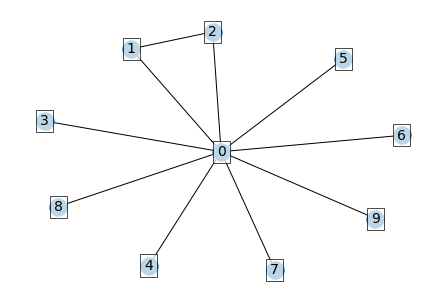

Random Gnp Graph with 9 nodes and 11 edges


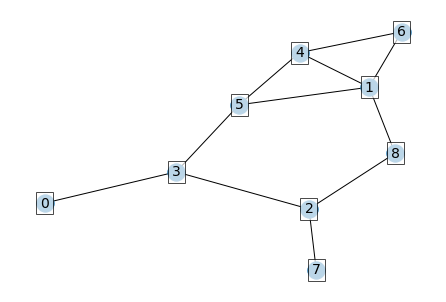

In [66]:
gnl = generate_gnl_random(10, 10)
print("Random Gnm", nx.info(gnl))
plot(gnl)
gnp = generate_gnp_random(10, 0.25)
print("Random Gnp", nx.info(gnp))
plot(gnp)

Random Gnm Graph with 10 nodes and 30 edges


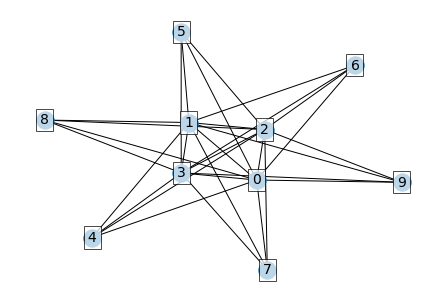

Random Gnp Graph with 9 nodes and 10 edges


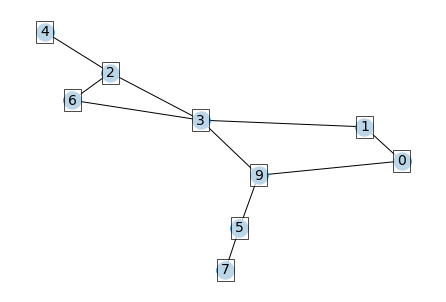

Barabasi-Albert Graph with 10 nodes and 9 edges


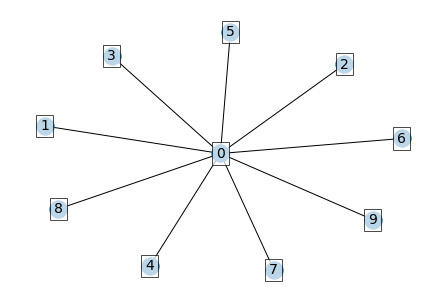

Random Gnm Graph with 50 nodes and 150 edges


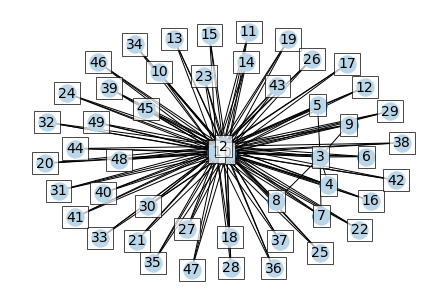

Random Gnp Graph with 50 nodes and 297 edges


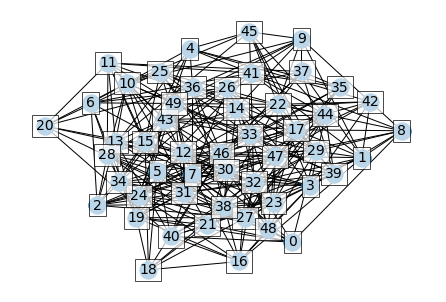

Barabasi-Albert Graph with 50 nodes and 369 edges


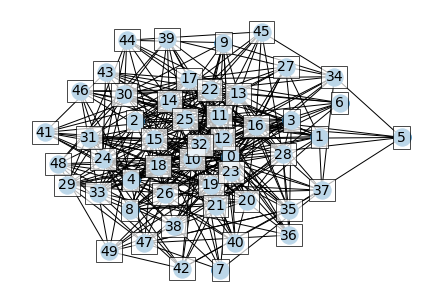

Random Gnm Graph with 100 nodes and 300 edges


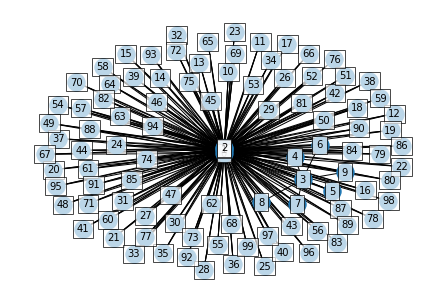

Random Gnp Graph with 100 nodes and 1231 edges


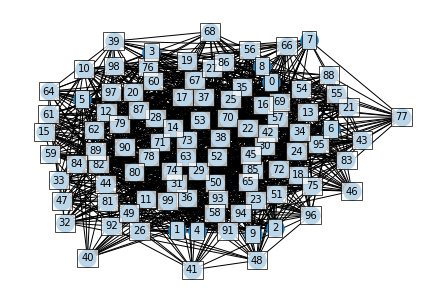

Barabasi-Albert Graph with 100 nodes and 819 edges


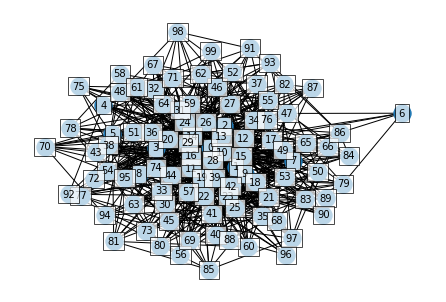

In [69]:
# Try altering these parameters!
G = nx.Graph()
N = int(1000)
L = int(1000)
p = 0.25
for N in [10, 50, 100]:
    gnl = generate_gnl_random(N, 3*N)
    print("Random Gnm", nx.info(gnl))
    plot(gnl)
    gnp = generate_gnp_random(N, p)
    print("Random Gnp", nx.info(gnp))
    plot(gnp)
    gba = nx.barabasi_albert_graph(N, 9)
    print("Barabasi-Albert", nx.info(gba))
    plot(gba)

# Degree Distributions

====================================================================== N = 100 ======================================================================
Degree Distribution:


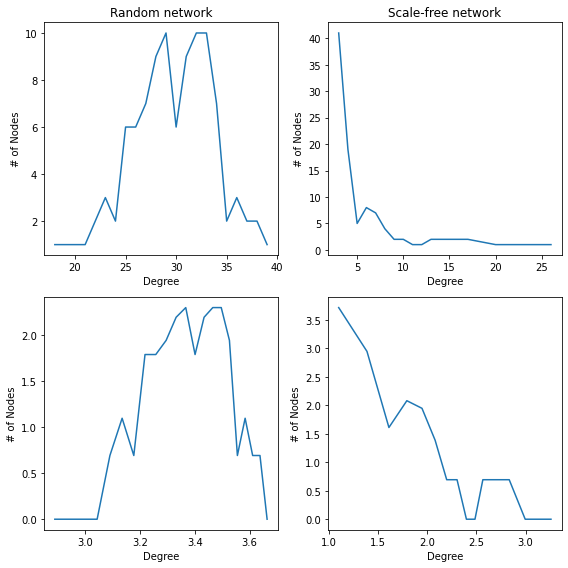

====================================================================== N = 500 ======================================================================
Degree Distribution:


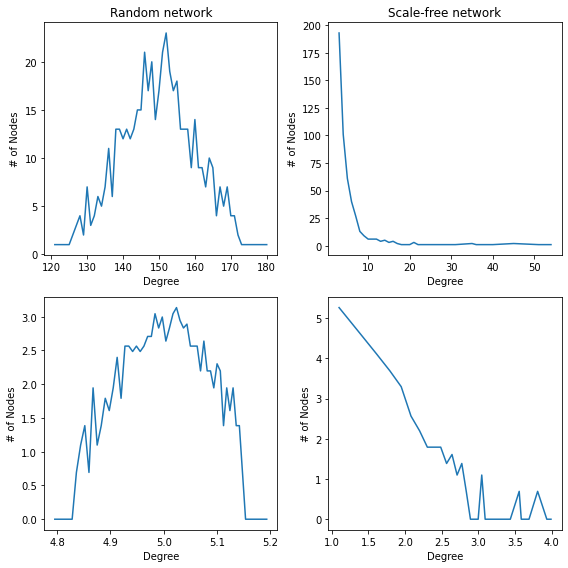

====================================================================== N = 1000 ======================================================================
Degree Distribution:


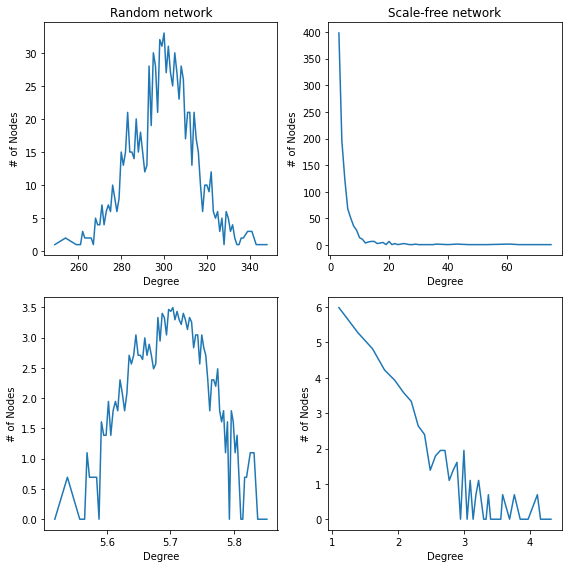

====================================================================== N = 5000 ======================================================================
Degree Distribution:


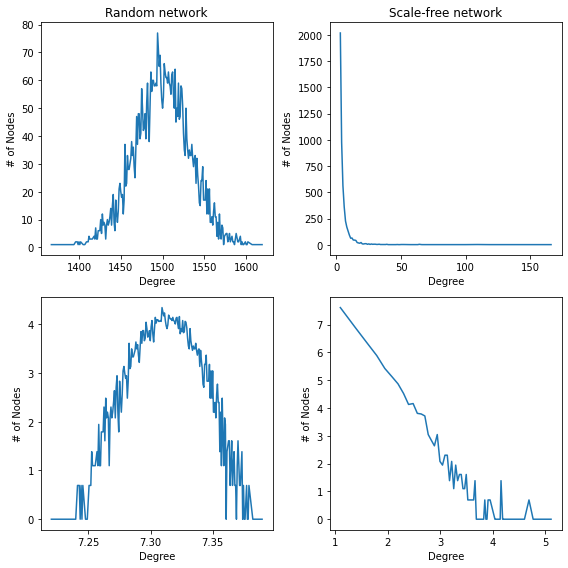

In [61]:
for N in [100, 500, 1000, 5000]:
    print("="*70+f" N = {N} "+"="*70)
    p = 0.3
    m = 3
    seed = 12345
    Gr = generate_gnp_random(N, p, seed=seed)
    Gs = nx.barabasi_albert_graph(N, m, seed=seed)
    '''
    Degree Distribution
    '''
    print("Degree Distribution:")
    degree_sequence_r = sorted([d for n, d in Gr.degree()], reverse=True)

    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    ax = plt.subplot(221)
    ax.plot(*np.unique(degree_sequence_r, return_counts=True))
    ax.set_title("Random network")
    ax.set_xlabel("Degree")
    ax.set_ylabel("# of Nodes")

    # Create a gridspec for adding subplots of different sizes
    ax3 = plt.subplot(223)
    deg_seq = np.unique(degree_sequence_r, return_counts=True)
    k = np.log(deg_seq[0])
    v = np.log(deg_seq[1])
    ax3.plot(k, v)
    ax3.set_xlabel("Degree")
    ax3.set_ylabel("# of Nodes")

    # print("="*30, "Degree Distribution", "="*30)
    degree_sequence_s = sorted([d for n, d in Gs.degree()], reverse=True)

    # Create a gridspec for adding subplots of different sizes
    ax2 = plt.subplot(222)
    ax2.plot(*np.unique(degree_sequence_s, return_counts=True))
    ax2.set_title("Scale-free network")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")


    # Create a gridspec for adding subplots of different sizes
    ax4 = plt.subplot(224)
    deg_seq = np.unique(degree_sequence_s, return_counts=True)
    k = np.log(deg_seq[0])
    v = np.log(deg_seq[1])
    ax4.plot(k,v)
    ax4.set_xlabel("Degree")
    ax4.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

# Structural Measures for a graph of 100 nodes

#### Utils

#### Random Graph

In [71]:
# Common parameters
seed=20532
nos = 20

============================== Node Count, Edge Count, Average Degree ==============================
Graph with 100 nodes and 990 edges
Average Degree: 2e+01


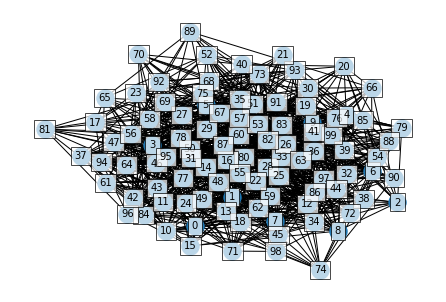

============================== Degree Distribution ==============================


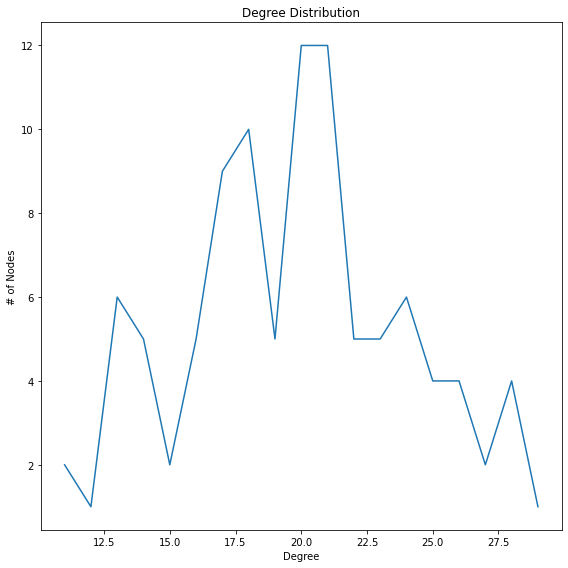

============================== Triangles ==============================
The number of triangles at nodes:
 0 :         38 1 :         48 2 :         14 3 :         57 4 :         45
 5 :         57 6 :         27 7 :         32 8 :         40 9 :         23
10 :         4611 :         3612 :         4013 :         3114 :         50
15 :         1516 :         6817 :         1418 :         2519 :         38
The total number of triangles in the graph is  1315.0

============================== Diameter ==============================
The diameter of the graph is 3

============================== Connected Components ==============================
Component 1      Length : 100
Total connected components in the graph: 1
Size of largest connected component:  100

============================== Clustering Coefficient ==============================
The clustering coefficient of node:
 0 : 0.20       1 : 0.17       2 : 0.15       3 : 0.19       4 : 0.21      
 5 : 0.21       6 : 0.18       7 : 0

In [80]:
################################
#                              #
#   Random Network - G(N, p)   #
#                              #
################################
N = 100
p = 0.2
G = generate_gnp_random(N, p, seed=seed)
'''
Node count, Edge count, average degree
'''
print("="*30, "Node Count, Edge Count, Average Degree", "="*30)
print(nx.info(G)) 
print(f"Average Degree: {sum(dict(nx.degree(G)).values())/len(G.nodes):.2}")
'''
Plot graph
'''
plot(G, seed=seed)
plt.show()
'''
Degree Distribution
'''
print("="*30, "Degree Distribution", "="*30)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
ax = plt.subplot(111)
ax.plot(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree Distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()
'''
Number of Triangles
'''
print("="*30, "Triangles", "="*30)
ntrid = nx.triangles(G)
print("The number of triangles at nodes:")
for i in range(nos):
    print(f"{i:2}", ":", f"{ntrid[i]:10}", end='')
    if i % 5 == 4:
        print()
print("The total number of triangles in the graph is ", sum(ntrid.values())/3)
print()
'''
 Diameter
'''
print("="*30, "Diameter", "="*30)
d = nx.diameter(G)
print("The diameter of the graph is", d)
print()
'''
Connected Components
'''
print("="*30, "Connected Components", "="*30)
count = 0
comps = nx.connected_components(G)
largest_cc = 0
for comp in comps:
    count+=1
    print("Component", count, "     Length :", len(comp))
    if len(comp) > largest_cc:
        largest_cc = len(comp)
print("Total connected components in the graph:", count)
print("Size of largest connected component: ", largest_cc)
print()
'''
Clustering Coefficient
'''
print("="*30, "Clustering Coefficient", "="*30)
nclust = nx.clustering(G)
print("The clustering coefficient of node:")
for i in range(nos):
    print(f"{i:2} : {nclust[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print(f"The average clustering coefficient of the graph is {sum(nclust.values())/len(G.nodes):.2f}")
print()

'''
Degree Centrality
'''
print("="*30, "Degree Centrality", "="*30)
degree_c = nx.degree_centrality(G)
for i in range(nos):
    print(f"{i:2} : {degree_c[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

'''
Closeness Centrality
'''
print("="*30, "Closeness Centrality", "="*30)
for i in range(nos):
    print(f"{i:2} : {nx.closeness_centrality(G, i):<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

'''
Betweenness Centrality
'''
print("="*30, "Betweenness Centrality", "="*30)
betweenness = nx.betweenness_centrality(G, 10, seed=seed)
for i in range(nos):
    print(f"{i:2} : {betweenness[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

'''
Eigenvector Centrality
'''
print("="*30, "Eigenvector Centrality", "="*30)
eigenvector = nx.eigenvector_centrality_numpy(G)
for i in range(nos):
    print(f"{i:2} : {eigenvector[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

#### Scale Free Network

============================== Node Count, Edge Count, Average Degree ==============================
Graph with 100 nodes and 819 edges
Average Degree: 1.6e+01


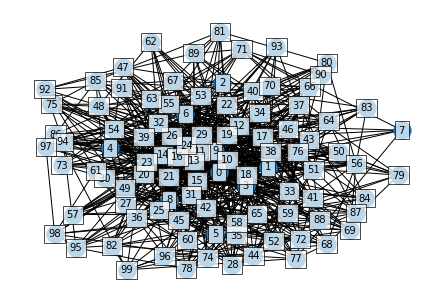

============================== Degree Distribution ==============================


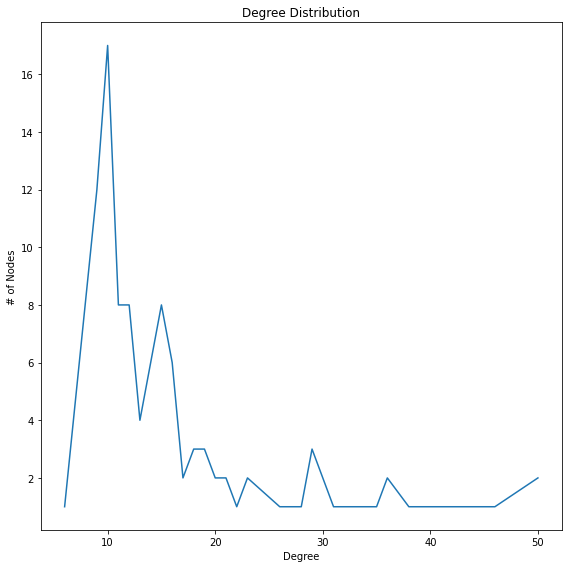

============================== Triangles ==============================
The number of triangles at nodes:
 0 :        291 1 :         80 2 :         34 3 :        129 4 :         46
 5 :         24 6 :         55 7 :          6 8 :         67 9 :         56
10 :        25911 :        20512 :        15413 :        16014 :        159
15 :        14016 :        13217 :         8918 :        11119 :        100
The total number of triangles in the graph is  1385.0

============================== Diameter ==============================
The diameter of the graph is 3

============================== Connected Components ==============================
Component 1      Length : 100
Total connected components in the graph: 1
Size of largest connected component:  100

============================== Clustering Coefficient ==============================
The clustering coefficient of node:
 0 : 0.24       1 : 0.23       2 : 0.32       3 : 0.28       4 : 0.34      
 5 : 0.36       6 : 0.36       7 : 0

In [78]:
#####################################
#                                   #
#  Scale - Free Network - G(N, p)   #
#                                   #
#####################################
N = 100
m = 9
G = nx.barabasi_albert_graph(N, m, seed=seed)
'''
Node count, Edge count, average degree
'''
print("="*30, "Node Count, Edge Count, Average Degree", "="*30)
print(nx.info(G)) 
print(f"Average Degree: {sum(dict(nx.degree(G)).values())/len(G.nodes):.2}")
'''
Plot graph
'''
plot(G, seed=seed)
plt.show()
'''
Degree Distribution
'''
print("="*30, "Degree Distribution", "="*30)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
ax = plt.subplot(111)
ax.plot(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree Distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()
'''
Number of Triangles
'''
print("="*30, "Triangles", "="*30)
ntrid = nx.triangles(G)
print("The number of triangles at nodes:")
for i in range(nos):
    print(f"{i:2}", ":", f"{ntrid[i]:10}", end='')
    if i % 5 == 4:
        print()
print("The total number of triangles in the graph is ", sum(ntrid.values())/3)
print()
'''
 Diameter
'''
print("="*30, "Diameter", "="*30)
d = nx.diameter(G)
print("The diameter of the graph is", d)
print()
'''
Connected Components
'''
print("="*30, "Connected Components", "="*30)
count = 0
comps = nx.connected_components(G)
largest_cc = 0
for comp in comps:
    count+=1
    print("Component", count, "     Length :", len(comp))
    if len(comp) > largest_cc:
        largest_cc = len(comp)
print("Total connected components in the graph:", count)
print("Size of largest connected component: ", largest_cc)
print()
'''
Clustering Coefficient
'''
print("="*30, "Clustering Coefficient", "="*30)
nclust = nx.clustering(G)
print("The clustering coefficient of node:")
for i in range(nos):
    print(f"{i:2} : {nclust[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print(f"The average clustering coefficient of the graph is {sum(nclust.values())/len(G.nodes):.2f}")
print()

'''
Degree Centrality
'''
print("="*30, "Degree Centrality", "="*30)
degree_c = nx.degree_centrality(G)
for i in range(nos):
    print(f"{i:2} : {degree_c[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

'''
Closeness Centrality
'''
print("="*30, "Closeness Centrality", "="*30)
for i in range(nos):
    print(f"{i:2} : {nx.closeness_centrality(G, i):<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

'''
Betweenness Centrality
'''
print("="*30, "Betweenness Centrality", "="*30)
betweenness = nx.betweenness_centrality(G, 10, seed=seed)
for i in range(nos):
    print(f"{i:2} : {betweenness[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

'''
Eigenvector Centrality
'''
print("="*30, "Eigenvector Centrality", "="*30)
eigenvector = nx.eigenvector_centrality_numpy(G)
for i in range(nos):
    print(f"{i:2} : {eigenvector[i]:<10.2f}", end='')
    if i % 5 == 4:
        print()
print()

# Timing Benchmarks for generate_nl_random() function

In [1]:
# Install Ray for parallelism
print('NOTE: Intentionally crashing session to use the newly installed library.\n')

!pip uninstall -y pyarrow
!pip install ray[default]
!pip install bs4

try:
  import ray
except:
  # A hack to force the runtime to restart, needed to include the above dependencies.
  import os
  os._exit(0)

NOTE: Intentionally crashing session to use the newly installed library.



In [2]:
import networkx as nx
import ray
import numpy as np
import random
from itertools import combinations
import pandas as pd
from timeit import default_timer as timer
import multiprocessing as mp 
from tqdm import tqdm

# init ray for parallel processing
ray.init(ignore_reinit_error=True)

2021-10-11 18:23:31,229	INFO services.py:1252 -- View the Ray dashboard at http://127.0.0.1:8265


{'metrics_export_port': 40967,
 'node_id': 'b078c9146b0334e25a6f2966bdef0b0c150f8e6e5fefc78ce647b20c',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-10-11_18-23-29_386392_759/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-10-11_18-23-29_386392_759/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-10-11_18-23-29_386392_759',
 'webui_url': '127.0.0.1:8265'}

In [3]:
def batch_gen(gen, batch_size: int):
    batch_items = []
    item_count = 0
    for item in gen:
        batch_items.append(item)
        item_count += 1
        if item_count % batch_size == 0:
            yield batch_items
            batch_items = []

In [4]:
# Version 0.4
def sample_and_add_edges_to_G(N: int, start_p: float, L: int = 0, batch_size_divisor = 100, seed = None):
    G = nx.Graph() # empty undirected graph
    edge_count = 0  # number of edges added to the graph
    covered = 0 # counter on number of edges covered from the generator
    dynamic_p = False

    # total edges
    TOTAL_EDGES = int(N*(N-1)/2)

    if L > 0:
        dynamic_p = True
    else:
        L = int(start_p * TOTAL_EDGES)  # for gnp graph
    
    batch_size = int(L//batch_size_divisor)    # load edges from generator in batch sizes
    try:
        assert(batch_size > 0)
    except AssertionError as e:
        print(e)
        return

    p = start_p * np.ones(batch_size) # starting probability

    # initialize a batch generator
    edge_gen = batch_gen(combinations(range(N), 2), batch_size)
    
    # if not None, initialize seed for randomness to get same results
    rng = np.random.default_rng(seed)
    
    for batch in edge_gen:
        batch = np.array(batch)
        # print(batch.shape)
        
        covered_ratio = 1 - covered/TOTAL_EDGES
        added_edges_ratio = 1 - edge_count/L

        # if dynamic_probability, G(n,m) else G(n, p)
        if dynamic_p: 
            p = np.minimum(1, np.maximum(p, 1 - (covered_ratio - added_edges_ratio)))

        # generate random decision probabilities for every edge in the batch
        pgen = rng.random(batch_size)
        
        # find booleans to decide whether to add edges or not 
        candidate_edges = p >= pgen
        edge_count += np.sum(candidate_edges)
        covered += batch_size
        if edge_count > L:
            edge_count -= np.sum(candidate_edges)
            break
        G.add_edges_from(batch[candidate_edges])
    # print(edge_count, L, N, p, batch_size)
    # add remaining edges    
    if edge_count < L:
        # print(L - edge_count, batch_size, L, edge_count)
        try:
            rem_edges = rng.choice(batch, L - edge_count, replace=False)
        except:
            # print(edge_count, L, N, p, batch_size, L-edge_count)
            return G
        G.add_edges_from(rem_edges)
    return G

def generate_gnl_random(N, L, batch_size_divisor, seed=None):
    G = sample_and_add_edges_to_G(N, start_p=0.5, L=L, batch_size_divisor=batch_size_divisor, seed=seed)
    # print(nx.info(G))
    return G

def generate_gnp_random(N, p, seed=None):
    TOTAL_EDGES = int(N*(N-1)/2)
    L = TOTAL_EDGES*p
    batch_size_divisor = 100
    if L//batch_size_divisor > 0:
        G = sample_and_add_edges_to_G(N, start_p=p, batch_size_divisor=batch_size_divisor, seed=seed)
    # print(nx.info(G))
        return G

In [8]:
@ray.remote
def _benchmark_gnl(N, L, batch_size_divisor, rep):   
    TOTAL_EDGES = N*(N-1)/2
    res = []
    print(f"N={N}, L={L}, batch-size-divisor={batch_size_divisor}, rep={rep}")
    print("-"*70)
    # evaluate library function for best of 10 loops
    if TOTAL_EDGES // L > L // N:
        for i in range(10):
            start = timer()
            nx.gnm_random_graph(N, L)
            stop = timer()
            res.append(stop-start)
    else:
        for i in range(10):
            start =timer()
            nx.dense_gnm_random_graph(N, L)
            stop = timer()
            res.append(stop-start)
    a = min(res)

    # evaluated implemented algo for best of 10 loops
    res = []
    for i in range(10):
        start = timer()
        generate_gnl_random(N, L, batch_size_divisor)
        stop = timer()
        res.append(stop-start)
    b = min(res)
    return (N, L, batch_size_divisor, rep, a, b)

def run_benchmark_gnl_and_store_result():
    other = []
    for N in [100, 1000, 10000]:
        for L in [100000, 1000000]:
            for batch_size_divisor in [1, 10, 100]:
    # for N in [100]:
    #     for L in [100]:
    #         for batch_size_divisor in [1, 10, 100]:
                for rep in range(5):
                    TOTAL_EDGES = N*(N-1)/2
                    if L < N or L > TOTAL_EDGES:    # omittable cases
                        continue
                    other.append(_benchmark_gnl.remote(N, L, batch_size_divisor, rep))
    other = ray.get(other)
    # store result in dataframe 
    df = pd.DataFrame(other, columns=["N", "L", "batch-size-divisor", "rep", "nx-algo", "generate_gnl_random"])
    df = df.dropna()
    return df

In [9]:

def highlight_greaterthan(s, column):
    is_max = np.zeros_like(s.index)
    ls = len(s)
    if s.loc[column[1]] <= s.loc[column[0]]:
        return  ['background-color: #90ee90']*ls
    elif s.loc[column[0]] - s.loc[column[1]] < 0.01:
        return  ['background-color: #ffffe0']*ls
    else:
        return ['']*ls

def format_result(table, imp_algo_details):
    table.sort_values(["N", *imp_algo_details["param"]], axis=0, inplace=True)
    table = table.groupby(["N", *imp_algo_details["param"]]).aggregate(np.min).reset_index(drop=False).drop(columns=["rep"])
    return table, table.style.apply(
                        highlight_greaterthan, column=['nx-algo',  imp_algo_details["name"]], axis=1
                    ).format(
                        formatter={"nx-algo": "{:.4f}",
                            "generate_gnl_random": "{:.4f}"
                    })  
    

In [7]:
table = run_benchmark_gnl_and_store_result()
table, s = format_result(table, imp_algo_details={"param":["L", "batch-size-divisor"], "name":"generate_gnl_random"})
s

(_benchmark_gnl pid=928) N=100, L=100, batch-size-divisor=1, rep=1
(_benchmark_gnl pid=928) ----------------------------------------------------------------------
(_benchmark_gnl pid=929) N=100, L=100, batch-size-divisor=1, rep=0
(_benchmark_gnl pid=929) ----------------------------------------------------------------------
(_benchmark_gnl pid=928) N=100, L=100, batch-size-divisor=1, rep=2
(_benchmark_gnl pid=928) ----------------------------------------------------------------------
(_benchmark_gnl pid=928) N=100, L=100, batch-size-divisor=1, rep=4
(_benchmark_gnl pid=928) ----------------------------------------------------------------------
(_benchmark_gnl pid=928) N=100, L=100, batch-size-divisor=10, rep=1
(_benchmark_gnl pid=928) ----------------------------------------------------------------------
(_benchmark_gnl pid=928) N=100, L=100, batch-size-divisor=10, rep=3
(_benchmark_gnl pid=928) ----------------------------------------------------------------------
(_benchmark_gnl pid=

,N,L,batch-size-divisor,nx-algo,generate_gnl_random
0,100,100,1,0.0006,0.0011
1,100,100,10,0.0006,0.0014
2,100,100,100,0.0005,0.0049
3,100,1000,1,0.0125,0.0094
4,100,1000,10,0.0125,0.0079
5,100,1000,100,0.0123,0.0124
6,1000,1000,1,0.0073,0.0105
7,1000,1000,10,0.0068,0.0091
8,1000,1000,100,0.0065,0.0123
9,1000,10000,1,0.0639,0.0962


In [19]:
# generate output from the entire csv
table = pd.read_csv("/content/gnl.csv")
def format_result(table, imp_algo_details):
    return table, table.style.apply(
                        highlight_greaterthan, column=['nx-algo',  imp_algo_details["name"]], axis=1
                    )
table, s = format_result(table, imp_algo_details={"param":["L", "batch-size-divisor"], "name":"generate_gnl_random"})
s

,S. No.,N,L,batch-size-divisor,nx-algo,generate_gnl_random
0,1,100,100,1,0.000600,0.001100
1,2,100,100,10,0.000600,0.001400
2,3,100,100,100,0.000800,0.000900
3,4,100,1000,1,0.012500,0.009400
4,5,100,1000,10,0.012500,0.007900
5,6,100,1000,100,0.012600,0.010600
6,8,1000,1000,1,0.007300,0.010500
7,9,1000,1000,10,0.006800,0.009100
8,10,1000,1000,100,0.007600,0.009800
9,12,1000,10000,1,0.129100,0.101300


In [20]:
print(table.to_markdown())
table.to_csv("/content/gnl_part.csv")

|    |   S. No. |      N |      L |   batch-size-divisor |   nx-algo |   generate_gnl_random |
|---:|---------:|-------:|-------:|---------------------:|----------:|----------------------:|
|  0 |        1 |    100 |    100 |                    1 |    0.0006 |                0.0011 |
|  1 |        2 |    100 |    100 |                   10 |    0.0006 |                0.0014 |
|  2 |        3 |    100 |    100 |                  100 |    0.0008 |                0.0009 |
|  3 |        4 |    100 |   1000 |                    1 |    0.0125 |                0.0094 |
|  4 |        5 |    100 |   1000 |                   10 |    0.0125 |                0.0079 |
|  5 |        6 |    100 |   1000 |                  100 |    0.0126 |                0.0106 |
|  6 |        8 |   1000 |   1000 |                    1 |    0.0073 |                0.0105 |
|  7 |        9 |   1000 |   1000 |                   10 |    0.0068 |                0.0091 |
|  8 |       10 |   1000 |   1000 |               

|    |   S. No. |      N |      L |   batch-size-divisor |   nx-algo |   generate_gnl_random |
|---:|---------:|-------:|-------:|---------------------:|----------:|----------------------:|
|  0 |        1 |    100 |    100 |                    1 |    0.0006 |                0.0011 |
|  1 |        2 |    100 |    100 |                   10 |    0.0006 |                0.0014 |
|  2 |        3 |    100 |    100 |                  100 |    0.0008 |                0.0009 |
|  3 |        4 |    100 |   1000 |                    1 |    0.0125 |                0.0094 |
|  4 |        5 |    100 |   1000 |                   10 |    0.0125 |                0.0079 |
|  5 |        6 |    100 |   1000 |                  100 |    0.0126 |                0.0106 |
|  6 |        8 |   1000 |   1000 |                    1 |    0.0073 |                0.0105 |
|  7 |        9 |   1000 |   1000 |                   10 |    0.0068 |                0.0091 |
|  8 |       10 |   1000 |   1000 |                  100 |    0.0076 |                0.0098 |
|  9 |       12 |   1000 |  10000 |                    1 |    0.1291 |                0.1013 |
| 10 |       13 |   1000 |  10000 |                   10 |    0.0694 |                0.077  |
| 11 |       14 |   1000 |  10000 |                  100 |    0.0639 |                0.1324 |
| 12 |       15 |   1000 | 100000 |                    1 |    1.5307 |                1.0861 |
| 13 |       16 |   1000 | 100000 |                   10 |    1.4517 |                0.9445 |
| 14 |       17 |   1000 | 100000 |                  100 |    1.4823 |                0.8798 |
| 15 |       18 |  10000 |  10000 |                    1 |    0.0947 |                0.1082 |
| 16 |       19 |  10000 |  10000 |                   10 |    0.095  |                0.0882 |
| 17 |       20 |  10000 |  10000 |                  100 |    0.1065 |                0.101  |
| 18 |       23 |  10000 | 100000 |                    1 |    0.907  |                1.1837 |
| 19 |       24 |  10000 | 100000 |                   10 |    0.8788 |                0.8928 |
| 20 |       25 |  10000 | 100000 |                  100 |    0.9024 |                0.8325 |
| 21 |       26 | 100000 | 100000 |                    1 |    1.3615 |                1.5068 |
| 22 |       27 | 100000 | 100000 |                   10 |    1.405  |                1.2273 |
| 23 |       28 | 100000 | 100000 |                  100 |    0.9957 |                0.7811 |

# Timing Benchmarks for generate_np_random() function

In [21]:
@ray.remote
def _benchmark_gnp(N, p, rep):   
    res = []
    print(f"N={N}, p={p}")
    print("-"*70)
    # evaluate library function for best of 10 loops
    if p < 0.35:
        for i in range(10):
            start = timer()
            nx.fast_gnp_random_graph(N, p)
            stop = timer()
            res.append(stop-start)
    else:
        for i in range(10):
            start =timer()
            nx.gnp_random_graph(N, p)
            stop = timer()
            res.append(stop-start)
    a = min(res)

    # evaluated implemented algo for best of 10 loops
    res = []
    for i in range(10):
        start = timer()
        generate_gnp_random(N, p)
        stop = timer()
        res.append(stop-start)
    b = min(res)
    return (N, p, rep, a, b)

def run_benchmark_gnp_and_store_result():
    other = []
    # for N in [100, 1000, 10000, 100000]:
    #     for L in [100, 1000, 10000, 100000]:
    for N in [100, 1000]:
        for p in [10**i for i in range(-4, 0)]:
            if N*p <= 0:
                continue
            
            for rep in range(5):
                other.append(_benchmark_gnp.remote(N, p, rep))
    other = ray.get(other)
    # store result in dataframe 
    df = pd.DataFrame(other, columns=["N", "p",  "rep", "nx-algo", "generate_gnp_random"])
    df = df.dropna()
    return df

In [22]:
table=run_benchmark_gnp_and_store_result()
table, s = format_result(table, imp_algo_details={"param":"p", "name":"generate_gnp_random"})
s

(_benchmark_gnp pid=928) N=10000, p=0.0001
(_benchmark_gnp pid=928) ----------------------------------------------------------------------
(_benchmark_gnp pid=929) N=10000, p=0.0001
(_benchmark_gnp pid=929) ----------------------------------------------------------------------


KeyboardInterrupt: ignored

In [10]:
print(table.to_markdown())

|    |    N |      p |     nx-algo |   generate_gnp_random |
|---:|-----:|-------:|------------:|----------------------:|
|  0 |  100 | 0.0001 | 0.000137874 |             8.92e-07  |
|  1 |  100 | 0.001  | 0.000157716 |             8.46e-07  |
|  2 |  100 | 0.01   | 0.000273931 |             1.002e-06 |
|  3 |  100 | 0.1    | 0.00144551  |             0.0518144 |
|  4 | 1000 | 0.0001 | 0.00187025  |             9.8e-07   |
|  5 | 1000 | 0.001  | 0.00339598  |             4.60065   |
|  6 | 1000 | 0.01   | 0.0197008   |             1.48191   |
|  7 | 1000 | 0.1    | 0.112917    |             0.811151  |


|    |    N |      p |     nx-algo |   generate_gnp_random |
|---:|-----:|-------:|------------:|----------------------:|
|  0 |  100 | 0.0001 | 0.000137874 |             8.92e-07  |
|  1 |  100 | 0.001  | 0.000157716 |             8.46e-07  |
|  2 |  100 | 0.01   | 0.000273931 |             1.002e-06 |
|  3 |  100 | 0.1    | 0.00144551  |             0.0518144 |
|  4 | 1000 | 0.0001 | 0.00187025  |             9.8e-07   |
|  5 | 1000 | 0.001  | 0.00339598  |             4.60065   |
|  6 | 1000 | 0.01   | 0.0197008   |             1.48191   |
|  7 | 1000 | 0.1    | 0.112917    |             0.811151  |